In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import cv2
from common import *
from models import *
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

print(tf. __version__) 
# print('tensorflow version', tf.__version__)
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

2.3.0
Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code


# Global variables

In [2]:
SEED_VALUE = 70707070
np.random.seed(SEED_VALUE)
SAVE_FIGURES = False

# Reading data and resizing

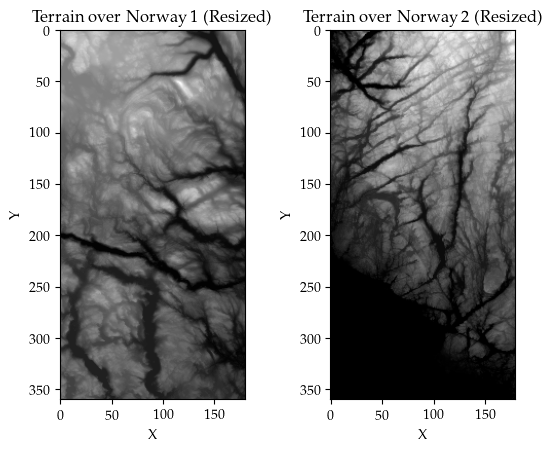

In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')

if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}terrain_data_resized.pdf")
plt.show()

# Creating image patches and Terrain data selection

In [4]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain1_patches.pdf")
    plt.show()

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain2_patches.pdf")
    plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60


# Real Terrain data

In [5]:
np.random.seed(4155)

degree = 1
X = create_X(x,y, degree)
X = X[:,1:]

X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True)

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

lr_upper_limit = learning_rate_upper_limit(X_train)

Upper limit learing rate: 0.9900859685598116


# Comparing own NN implementation against sklearn and tensorflow

In [6]:
# Parameters
epochs = 100
batch_size = 100
eta = 0.001
nbf_features = X_train.shape[1]
use_l2 = True
lmb = 0.00001
hidden_size = 25
act_func = "sigmoid"

In [7]:
own_model, sk_model, tf_model = NN_regression_comparison(eta, nbf_features, 
                                                         batch_size, epochs, 
                                                         X_test=X_test.copy(), 
                                                         t_test=t_test.copy(),
                                                         lmb=lmb, hidden_size=hidden_size, 
                                                         act_func=act_func,
                                                         )
# Own model
_, _ = own_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=False)
t_hat_test_own = own_model.predict(X_test.copy())
print("MSE using own implemented NN:",MSE(t_test, t_hat_test_own),"\n")

# SK learn
sk_model.fit(X_train.copy(), t_train.copy().ravel())
t_hat_test_sk_model = sk_model.predict(X_test.copy())
print("MSE using SK learn NN:", MSE(t_test, t_hat_test_sk_model),"\n")

# Tensorflow 
tf_model.fit(X_train.copy(), t_train.copy(), epochs=epochs,  batch_size=batch_size, verbose=0)
t_hat_test_tf = tf_model.predict(X_test.copy())
print("MSE using tensorflow NN:",MSE(t_test, t_hat_test_tf))

MSE using own implemented NN: 1.02727424825138 



C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE using SK learn NN: 0.8739440390195808 

MSE using tensorflow NN: 0.8878573853468466


# Grid search using simple architecture

### Parameters

In [8]:
epochs = 100
batch_size = 300
nbf_features = X_train.shape[1]
apply_lr_scheduler = False
hidden_sizes = np.array([32,16,8])
eta_list = np.logspace(-1, -4, 6)
lmb_list = np.concatenate([np.zeros(1).astype(float), np.logspace(-5, -3, 5)], axis=0)
act_func = "sigmoid"

### Grid search small architecture

In [9]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_simple_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_simple_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_B}own_NN_best_training_small_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\n{act_func}")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_B}own_NN_best_training_small_{act_func}_lr_{eta}.pdf")

                filename = f"../data/models/best_small_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_simple_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_simple_df.to_csv(f"{REPORT_DATA}{EX_B}results_small_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="small", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_B}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.8494
New best MSE tensorflow: 0.6451
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.5734
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.0003

1it [02:26, 146.85s/it]

Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.4949
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-

2it [04:49, 144.67s/it]

Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.466
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00

3it [06:48, 136.03s/it]


# Grid search using large architecture

### Parameters
Using same parameters as the small architecture

In [10]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_large_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_large_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_B}own_NN_best_training_large_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\n{act_func}")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_B}own_NN_best_training_large_{act_func}_lr_{eta}.pdf")

                filename = f"../data/models/best_large_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_large_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_large_df.to_csv(f"{REPORT_DATA}{EX_B}results_large_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="large", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_B}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.9612
New best MSE tensorflow: 1.0058
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.9955
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -

1it [06:39, 399.20s/it]

Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.9449
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parame

2it [11:16, 327.37s/it]

Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.0001
Neurons in first

3it [14:02, 280.80s/it]


### Grid search

In [11]:
a=k

NameError: name 'k' is not defined

# Tests

# XOR classification test
The following code checks that a Fixed neural net is able to correctly classify the XOR problem

In [ ]:
"""np.random.seed(4155)
X = np.array([[1, 0],
              [0, 1],
              [1, 1],
              [0, 0]])

hidden1 = Fixed_layer(nbf_inputs=2, nbf_outputs=2, weights=np.array([[1,1],[1,1]]), bias=np.array([-1.5, -0.5]), activation_function=binary_classifier)
output = Fixed_layer(nbf_inputs=2, nbf_outputs=1, weights=np.array([-1,1]), bias=np.array([-0.5]), activation_function=binary_classifier)

model = NeuralNetwork()
model.add(hidden1)
model.add(output)

y_hat = model.predict(X)
print(f"y_hat: {y_hat}")"""

# Neural Net on XOR problem

In [ ]:
#np.random.seed(4155)
X_train = np.array([[1., 0.],
              [1., 1.],
              
              [0., 1.]])

X_test = np.array([[0., 0.]]) 

t = np.array([[1.,0.,1.]]).reshape(-1,1)

#hidden1 = Layer(nbf_inputs=2, nbf_outputs=4, activation_function=relu)
#hidden2 = Layer(nbf_inputs=hidden1.output, nbf_outputs=16)
hidden1 = Layer(nbf_inputs=2, nbf_outputs=2, activation=relu, name="hidden1")
output = Layer(nbf_inputs=hidden1.output, nbf_outputs=1, name="output")

model2 = NeuralNetwork()
model2.add(hidden1)
model2.add(output)

epochs = 100
batch_size = 2
model2.train_model(X_train, t, batch_size=batch_size, epochs=epochs)
y_hat = model2.predict(X_test)
print(y_hat)

In [ ]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(hidden_layer_sizes=(2,), max_iter=100, solver="sgd",learning_rate_init=0.001, activation="relu")
for i in range(10):
    clf.fit(X, t.flatten())
print(clf.predict(X_test))

# Tensorflow model

In [ ]:
# Parameters
epochs = 100
batch_size = 2
eta = 0.001

# Creating the model
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Input(shape=(2,)))
tf_model.add(tf.keras.layers.Dense(2, activation='relu'))
tf_model.add(tf.keras.layers.Dense(1))
tf_model.compile(loss='mse', optimizer=tf.optimizers.SGD(learning_rate=eta))


# Model training
tf_model.fit(X_train, t, epochs=epochs,  batch_size=batch_size, verbose=1)

# Model predictions
y_hat = tf_model.predict(X_test)
print(y_hat)

In [ ]:
np.random.seed(4155)
X_train = np.array([[1., 0.]])
t_train = np.array([[1.]]).reshape(-1,1)


hidden1 = Fixed_layer(nbf_inputs=2, nbf_outputs=2, weights=np.array([[1.,0.],[1.,0.]]), bias=np.array([0.01, 0.01]), activation="sigmoid")
output = Fixed_layer(nbf_inputs=2, nbf_outputs=1, weights=np.array([[1.],[0.]]), bias=np.array([0.01]), activation="sigmoid")

model = NeuralNetwork(learning_rate=1.0)
model.add(hidden1)
model.add(output)


pred = model.predict(X_train)
print(pred)

In [ ]:
print(model.sequential_layers[0].z)
print(model.sequential_layers[0].a)

In [ ]:
print(model.sequential_layers[-1].z)
print(model.sequential_layers[-1].a)

In [ ]:
print("X_train.shape:",X_train.shape)
print("t_train.shape:",t_train.shape)
model.train_model(X_train, t_train, epochs=1, batch_size=1)

In [ ]:
print(sigmoid(1+0.01) + 0.01)
print(sigmoid(sigmoid(1+0.01) + 0.01))
print(sigmoid(1+0.01) + 0.01)


print(sigmoid(1+0.01)*(1-sigmoid(1+0.01)))

print(0.3323*0.1957)

print(-(sigmoid(+0.01) * 0.3323 ))

In [ ]:
a = np.arange(9)
print(a)

b = a <= 3
print(b)

In [ ]:
nbf_inputs = 10
nbf_neurons = 3
weights = np.random.randn(nbf_inputs, nbf_neurons)
nbf_weights = weights.size
print(nbf_weights)

In [ ]:
import numpy as np
print(np.concatenate([np.array([0.5]), np.logspace(-1, -4, 10)], axis=0))

In [ ]:
eta_list = np.logspace(-1, -4, 7)
lmb_list = np.concatenate([np.zeros(1).astype(float), np.logspace(-5, -2, 6)], axis=0)

print(eta_list)
print(lmb_list)